In [19]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import time
from tqdm import tqdm_notebook
from sklearn.semi_supervised import label_propagation
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats
from sklearn.decomposition import PCA

### 1  加载数据

In [2]:
dataSet = pd.read_csv('../Cs137data/re_bp_SetData.csv')
dataSet.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
0,0,97.0,101.0,77.0,74.0,90.0,88.0,30.0,29.0,241.0,...,37.0,33.0,195.0,196.0,34.0,31.0,42.0,44.0,77.0,0.0
1,1,79.0,74.0,141.0,143.0,235.0,237.0,32.0,31.0,68.0,...,90.0,88.0,31.0,31.0,58.0,60.0,28.0,27.0,26.0,0.0
2,2,82.0,85.0,51.0,51.0,52.0,53.0,119.0,119.0,152.0,...,38.0,67.0,66.0,134.0,134.0,32.0,33.0,98.0,100.0,0.0
3,3,46.0,49.0,30.0,29.0,85.0,85.0,62.0,62.0,245.0,...,34.0,103.0,101.0,52.0,52.0,82.0,78.0,46.0,46.0,0.0
4,4,50.0,50.0,232.0,232.0,30.0,36.0,180.0,181.0,88.0,...,53.0,58.0,45.0,43.0,67.0,67.0,64.0,63.0,28.0,0.0


In [10]:
X = dataSet.values[:, 1: 5001]
Y = dataSet.values[:, -1]

# 删除本底数据，得到新的训练数据
X1 = np.delete(X, np.where(Y == 0)[0], axis=0)
X1 = X1 / np.max(X1)
Y1 = np.delete(Y, np.where(Y == 0)[0], axis=0)
X1.shape, Y1.shape

((7317, 5000), (7317,))

In [11]:
rng = np.random.RandomState(2)
indices = np.arange(X1.shape[0])
rng.shuffle(indices)
indices.max()

7316

In [12]:
x_train = X1[indices[ :3000]]
y = Y1[indices[ :3000]]
x_train[:5, :], y[:5]

(array([[0.42971888, 0.7751004 , 0.7751004 , ..., 0.12851406, 0.12449799,
         0.21686747],
        [0.45783133, 0.58232932, 0.58634538, ..., 0.20883534, 0.22088353,
         0.38955823],
        [0.18875502, 0.18473896, 0.28915663, ..., 0.25702811, 0.24096386,
         0.13654618],
        [0.29718876, 0.30120482, 0.07228916, ..., 0.19277108, 0.19277108,
         0.18473896],
        [0.79116466, 0.15261044, 0.39759036, ..., 0.1124498 , 0.11646586,
         0.12449799]]), array([3., 3., 2., 2., 3.]))

In [13]:
n_total_sample = y.shape[0]
n_labeled_points = 500
max_iterations = 5

# 后面 2500 个数据未被标签
unlabeled_indices = np.arange(n_total_sample)[n_labeled_points: ]
unlabeled_indices.shape

(2500,)

In [14]:
y_train = np.copy(y)
y_train[unlabeled_indices] = -1
y_train

array([ 3.,  3.,  2., ..., -1., -1., -1.])

In [20]:
def data_pca(dataSet, COMPONENT_NUM):
    start = time.time()
    print("====>>===>>===>> PCA ")
    pca = PCA(n_components=COMPONENT_NUM, copy=True, whiten=False)  # 创建一个 PCA 对象
    pca.fit(dataSet)    # 构建 PCA 模型
    pcaXTrain = pca.transform(dataSet)
    # pcaXTest = pca.transform(x_test)
    print('pca time is %0.3fs' % (time.time() - start))
    return pcaXTrain

In [21]:
X1 = data_pca(X1, 0.95)
X1[: 5, ]

====>>===>>===>> PCA 
pca time is 143.552s


array([[ 4.42038159e+00,  8.57917234e-02, -3.09075014e-01, ...,
         9.10819946e-02,  1.97234393e-03, -1.47497017e-02],
       [ 4.34248476e+00,  2.82932737e-01,  3.02745594e-01, ...,
         1.59299290e-01, -2.16621990e-02,  2.09502261e-01],
       [ 4.34081479e+00, -1.07727230e-01,  6.13420402e-02, ...,
         2.81632415e-02,  2.75935421e-03,  1.20106537e-01],
       [ 4.26617736e+00,  2.86449078e-02,  4.90487192e-01, ...,
        -5.56877910e-02,  4.16500367e-02, -3.03900693e-02],
       [ 4.28606221e+00, -1.67505656e-01,  1.43922287e-01, ...,
        -1.64488462e-01,  1.78066734e-02, -4.25832159e-02]])

### 2 训练模型
#### keyValue = {'BenDi': 0, 'Cs137': 1, 'CsGo': 2, 'Cs': 1, 'G60': 3, 'Eu155': 4}

In [22]:
lp_model = label_propagation.LabelSpreading(gamma=0.25, max_iter=20)
lp_model.fit(x_train, y_train)

LabelSpreading(alpha=0.2, gamma=0.25, kernel='rbf', max_iter=20, n_jobs=None,
               n_neighbors=7, tol=0.001)

In [23]:
predicted_labels = lp_model.transduction_[unlabeled_indices]
# 未标记的样本点的真实标签
true_labels = y[unlabeled_indices]  
predicted_labels.shape, predicted_labels, true_labels

((2500,),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([2., 2., 1., ..., 3., 1., 3.]))

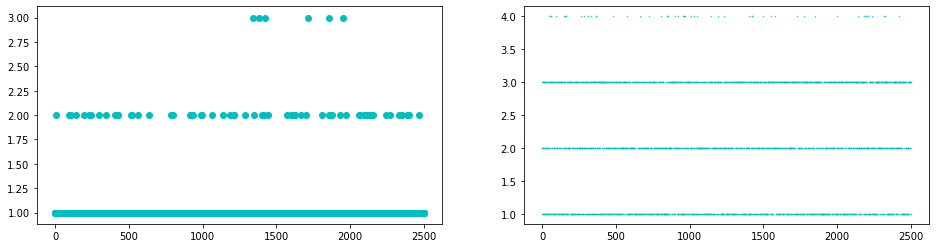

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))
axes[0].scatter(range(2500), predicted_labels, c='c')
axes[1].scatter(range(2500), true_labels, s=0.2, c='c')
plt.show()

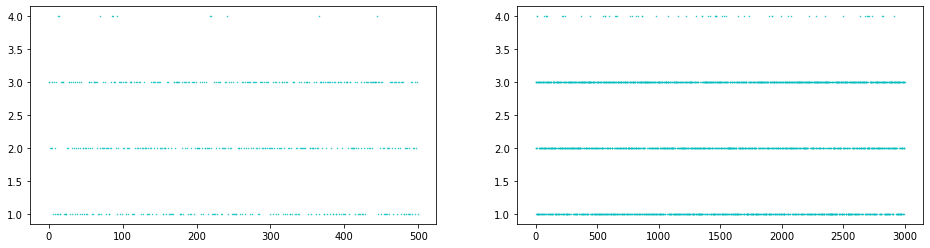

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))
axes[0].scatter(range(500), y_train[:500], s=0.2, c='c')
axes[1].scatter(range(3000), y, s=0.2, c='c')
plt.show()

### 3 度量训练效果

In [26]:
cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)
cm, cm.shape

(array([[787,   0,   0,   0],
        [741,   0,   0,   0],
        [855,  60,   6,   0],
        [ 51,   0,   0,   0]], dtype=int64), (4, 4))

In [27]:
print(classification_report(true_labels, predicted_labels))

e:\anaconda\envs\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         1.0       0.32      1.00      0.49       787
         2.0       0.00      0.00      0.00       741
         3.0       1.00      0.01      0.01       921
         4.0       0.00      0.00      0.00        51

    accuracy                           0.32      2500
   macro avg       0.33      0.25      0.13      2500
weighted avg       0.47      0.32      0.16      2500



In [98]:
pred_entropies = stats.distributions.entropy(lp_model.label_distributions_.T)
pred_entropies

array([ 0.,  0.,  0., ..., nan, nan, nan])

In [99]:
# select up to 5 digit examples that the classifier is most uncertain about
# 找到熵最大的索引值
uncertainty_index = np.argsort(pred_entropies)[::-1]
uncertainty_index = uncertainty_index[np.in1d(uncertainty_index, unlabeled_indices)][:100]
uncertainty_index

array([2999, 1332, 1340, 1339, 1338, 1337, 1336, 1334, 1333, 1331, 1322,
       1330, 1329, 1328, 1327, 1326, 1325, 1324, 1341, 1342, 1343, 1344,
       1359, 1358, 1357, 1356, 1355, 1354, 1353, 1352, 1351, 1350, 1349,
       1348, 1347, 1346, 1345, 1323, 1321, 1361, 1293, 1300, 1299, 1298,
       1297, 1296, 1295, 1294, 1292, 1320, 1291, 1290, 1289, 1288, 1287,
       1286, 1285, 1301, 1302, 1303, 1304, 1319, 1318, 1317, 1316, 1315,
       1314, 1313, 1312, 1311, 1310, 1309, 1308, 1307, 1306, 1305, 1360,
       1362, 1283, 1411, 1418, 1417, 1416, 1415, 1414, 1413, 1412, 1410,
       1401, 1409, 1408, 1407, 1406, 1405, 1404, 1403, 1419, 1420, 1421,
       1422], dtype=int64)

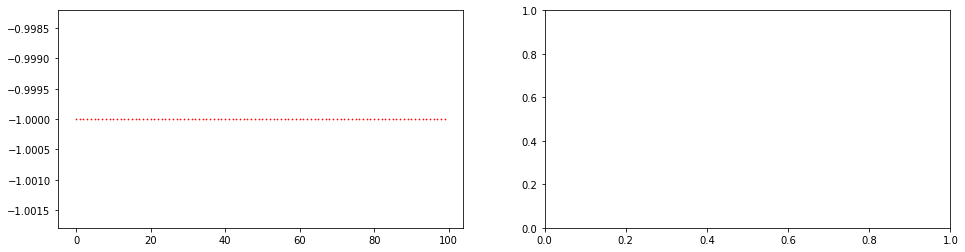

In [100]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))
axes[0].scatter(range(len(uncertainty_index)), y_train[uncertainty_index], s=0.5, c='r')
plt.show()


In [101]:
# keep track of indices that we get labels for
delete_indices = np.array([], dtype=int)

In [102]:
# labeling 5 points, remote from labeled set
for index, image_index in enumerate(uncertainty_index):
    # labeling 5 points, remote from labeled set
    # 找出熵最大的样本点在未标记索引中的位置
    delete_index, = np.where(unlabeled_indices == image_index)
    delete_indices = np.concatenate((delete_indices, delete_index))

unlabeled_indices = np.delete(unlabeled_indices, delete_indices)
n_labeled_points += len(uncertainty_index)
delete_indices, delete_indices.shape, n_labeled_points

(array([2499,  832,  840,  839,  838,  837,  836,  834,  833,  831,  822,
         830,  829,  828,  827,  826,  825,  824,  841,  842,  843,  844,
         859,  858,  857,  856,  855,  854,  853,  852,  851,  850,  849,
         848,  847,  846,  845,  823,  821,  861,  793,  800,  799,  798,
         797,  796,  795,  794,  792,  820,  791,  790,  789,  788,  787,
         786,  785,  801,  802,  803,  804,  819,  818,  817,  816,  815,
         814,  813,  812,  811,  810,  809,  808,  807,  806,  805,  860,
         862,  783,  911,  918,  917,  916,  915,  914,  913,  912,  910,
         901,  909,  908,  907,  906,  905,  904,  903,  919,  920,  921,
         922], dtype=int64), (100,), 600)

### 3 第二次循环

In [103]:
y_train = np.copy(y)
y_train[unlabeled_indices] = -1
lp_model = label_propagation.LabelSpreading(gamma=0.25, max_iter=20)
lp_model.fit(x_train, y_train)
predicted_labels = lp_model.transduction_[unlabeled_indices]
# 未标记的样本点的真实标签
true_labels = y[unlabeled_indices]  
predicted_labels.shape, predicted_labels, true_labels

e:\anaconda\envs\deeplearning\lib\site-packages\sklearn\semi_supervised\label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


((2400,),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([2., 2., 1., ..., 2., 3., 1.]))

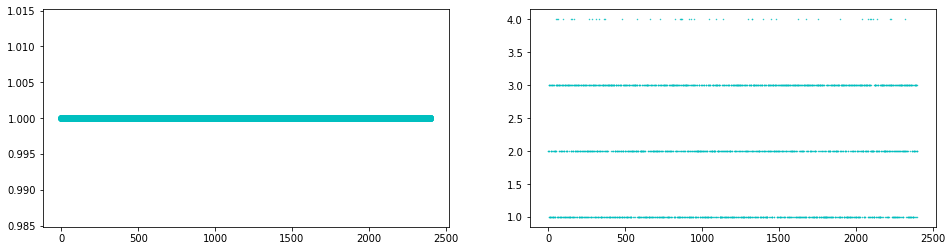

In [105]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))
axes[0].scatter(range(2400), predicted_labels, c='c')
axes[1].scatter(range(2400), true_labels, s=0.2, c='c')
plt.show()